In [1]:
import qiskit
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit
import qiskit_aer 
from qiskit.quantum_info import state_fidelity
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.quantum_info.states.random import random_statevector
from qiskit.circuit.library import Initialize
from qiskit.visualization import plot_bloch_multivector
import numpy as np
import matplotlib.pyplot as plt

from qiskit_aer.primitives import SamplerV2 as Sampler
from qiskit_aer.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info import Operator

In [2]:
from itertools import combinations, cycle
coeff_dict  = {}

def array_k1(num_qubits):  #assuming num_qubits is even
    array_k = []
    m = num_qubits/2
    if (m)%2!=0: #replace with m-1 for previous results
        for j in range(-int((m)//2),int((m)//2) + 1): #replace with m-1 for previous results
            array_k.append(2*np.pi*j/num_qubits)
    else:
        for j in range(-int((m)//2),int((m)//2)):
            array_k.append(2*np.pi*j/num_qubits)
    return array_k


def recursive_nested(l,num_qubits,coeff_array,coeff = 1,bitstr=''):

    m = int(num_qubits/2) # taking always even number of qubits

    #coeff_dict_2 = {}
    if l==m-1: # m-1, but we start with 0 indexing
        coeff_copy = coeff  #to ensure multiplied coeffs in previous rounds is preserved and reused
        bitstr_copy = bitstr
        for i in range(num_qubits):
            if str(i) in bitstr:
                pass
            else:
                coeff = coeff*coeff_array[l,i]
                bitstr = bitstr + f'{i}'
                bitstr_sorted = sort_bitstr(bitstr) #to sort the string first
                perm = perm_str2(bitstr,bitstr_sorted) # to compare hamming distance
                if bitstr_sorted in coeff_dict.keys():
                    coeff_dict[bitstr_sorted]+=coeff*perm
                else:
                    coeff_dict[bitstr_sorted] = coeff*perm
            bitstr = bitstr_copy
            coeff = coeff_copy
    if l!=m-1:
        coeff_copy = coeff  #to ensure multiplied coeffs in previous rounds is preserved and reused
        bitstr_copy = bitstr
        for i in range(num_qubits):
            if str(i) in bitstr:
                pass
            else:
                #print(coeff)
                coeff = coeff*coeff_array[l,i]
                bitstr += str(i)
                recursive_nested(l+1,num_qubits,coeff_array,coeff,bitstr)
            bitstr = bitstr_copy
            coeff = coeff_copy

    return coeff_dict

def sort_bitstr(bitstr):
    bit_array = []
    for i in bitstr:
        bit_array.append(i)
    #print(bit_array)
    bitstr_sorted = ''
    for i in range(len(bit_array)):
        bit_array[i] = int(bit_array[i])
    bit_array.sort()
    #print(bit_array)
    for i in bit_array:
        #print(i,str(i))
        bitstr_sorted += str(i)
        #print(bitstr_sorted)

    return bitstr_sorted

def perm_str2(cmpr,word):

   #  word = 'eyssaasse' base string
   # cmpr = 'seasysaes'  a string to find number of swaps from the base string
    swaps = 0

    # 1)
    chars = {c: [] for c in word}
    [chars[c].append(i) for i, c in enumerate(word)]
    for k in chars.keys():
        chars[k] = cycle(chars[k])

    # 2)
    idxs = [next(chars[c]) for c in cmpr]

    # 3)
    for cmb in combinations(idxs, 2):
        if cmb[0] > cmb[1]:
            swaps += 1

    #print(swaps)
    if swaps%2 == 0:
        return 1
    else:
        return -1

In [3]:
#Let us first initialize the circuit and the state

def fermi_state(num_qubits): #of the form num_qubits = 2*odd number


    coeff_dict.clear()
    m = int(num_qubits/2)
    coeff_array = []
    array_k = array_k1(num_qubits)
    for k in array_k:
        pos_list = []
        for x in range(num_qubits):
            pos_list.append(np.exp(-1j*k*x))
        coeff_array.append(pos_list)

    coeff_array = np.array(coeff_array)

    #print(coeff_array)

    coeff_dict_2 = recursive_nested(0,num_qubits,coeff_array)
    #print(coeff_dict_2)
    bitstr_dict = {}
    for bstr in coeff_dict_2.keys():
        vac_str = ''
        num_list = []
        for k in range(m):
            num_list.append(int(bstr[k]))

        for i in range(num_qubits):
            if i in num_list:
                vac_str += '1'
            else:
                vac_str += '0'
        bitstr_dict[vac_str] = coeff_dict[bstr]

    #print(bitstr_dict)
    

    fermi_state = Statevector([0]*(2**num_qubits))

    for bstr in bitstr_dict.keys():
        fermi_state += Statevector.from_label(bstr)*bitstr_dict[bstr]

    val_array = []
    for i in bitstr_dict.values():
        val_array.append(i)
    np_array = np.array(val_array)
    #print(np_array)
    #print(np.linalg.norm(np_array))
    
    fermi_state = fermi_state/np.linalg.norm(val_array)
    #print(fermi_state)
    fermi_state.is_valid()

    return fermi_state

In [4]:
N = 6 #number of sites (easier to apply fermi state to such site)
num_qubits = 2*N + 1

In [5]:
def fermi_state_circuit(N,num_cl_bits = 0):
    qc = QuantumCircuit(num_qubits,num_cl_bits)
    fermi_state_up = fermi_state(N)
    fermi_state_down = fermi_state(N)
    qc.initialize(fermi_state_up,range(N))
    qc.initialize(fermi_state_down,range(N+1,2*N+1))
    return qc

def fermi_state_circuit2(num_qubits,num_cl_bits = 0):
    qc = QuantumCircuit(num_qubits,num_cl_bits)
    fermi_state_up = fermi_state(int(num_qubits))
    qc.initialize(fermi_state_up,range(int(num_qubits)))
    return qc


def fermion_state(N,pos_list,num_cl_bits = 0):
    qc = QuantumCircuit(2*N+1,num_cl_bits)
    for i in range(2*N+1):
        if i in pos_list or i==N:
            continue
        else:
            qc.x(i)
    return qc

In [35]:
import math as m
import cmath as cm

def fsim(theta,phi,beta):
    fsim = Operator([[1,0,0,0],
                   [0,m.cos(theta),1j*cm.exp(1j*beta)*m.sin(theta),0],
                   [0,1j*cm.exp(-1j*beta)*m.sin(theta),m.cos(theta),0],
                   [0,0,0,cm.exp(1j*phi)]])
    return fsim

def add_fsim_half(qc,angles):
    theta = angles[0]
    phi = angles[1]
    beta = angles[2]

    fsim1 = fsim(theta,phi,beta)
    #Adding fsim in even layers
    for i in range(0,qc.num_qubits//2-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi)$')

    for i in range(qc.num_qubits//2+1,qc.num_qubits-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi)$')
        
    #Adding fsim in odd layers
    for i in range(1,qc.num_qubits//2-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi)$')

    for i in range(qc.num_qubits//2+2,qc.num_qubits-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi)$')

def add_fsim_inv_half(qc,angles):
    theta = angles[0]
    phi = angles[1]
    beta = angles[2]

    fsim1 = fsim(theta,phi,beta)

    #Adding fsim in odd layers
    for i in range(1,qc.num_qubits//2-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi)$')

    for i in range(qc.num_qubits//2+2,qc.num_qubits-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi)$')
        
    #Adding fsim in even layers
    for i in range(0,qc.num_qubits//2-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi)$')

    for i in range(qc.num_qubits//2+1,qc.num_qubits-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi)$')

In [36]:
test_trotter_steps = 2
angles = [np.pi/4,0,0]

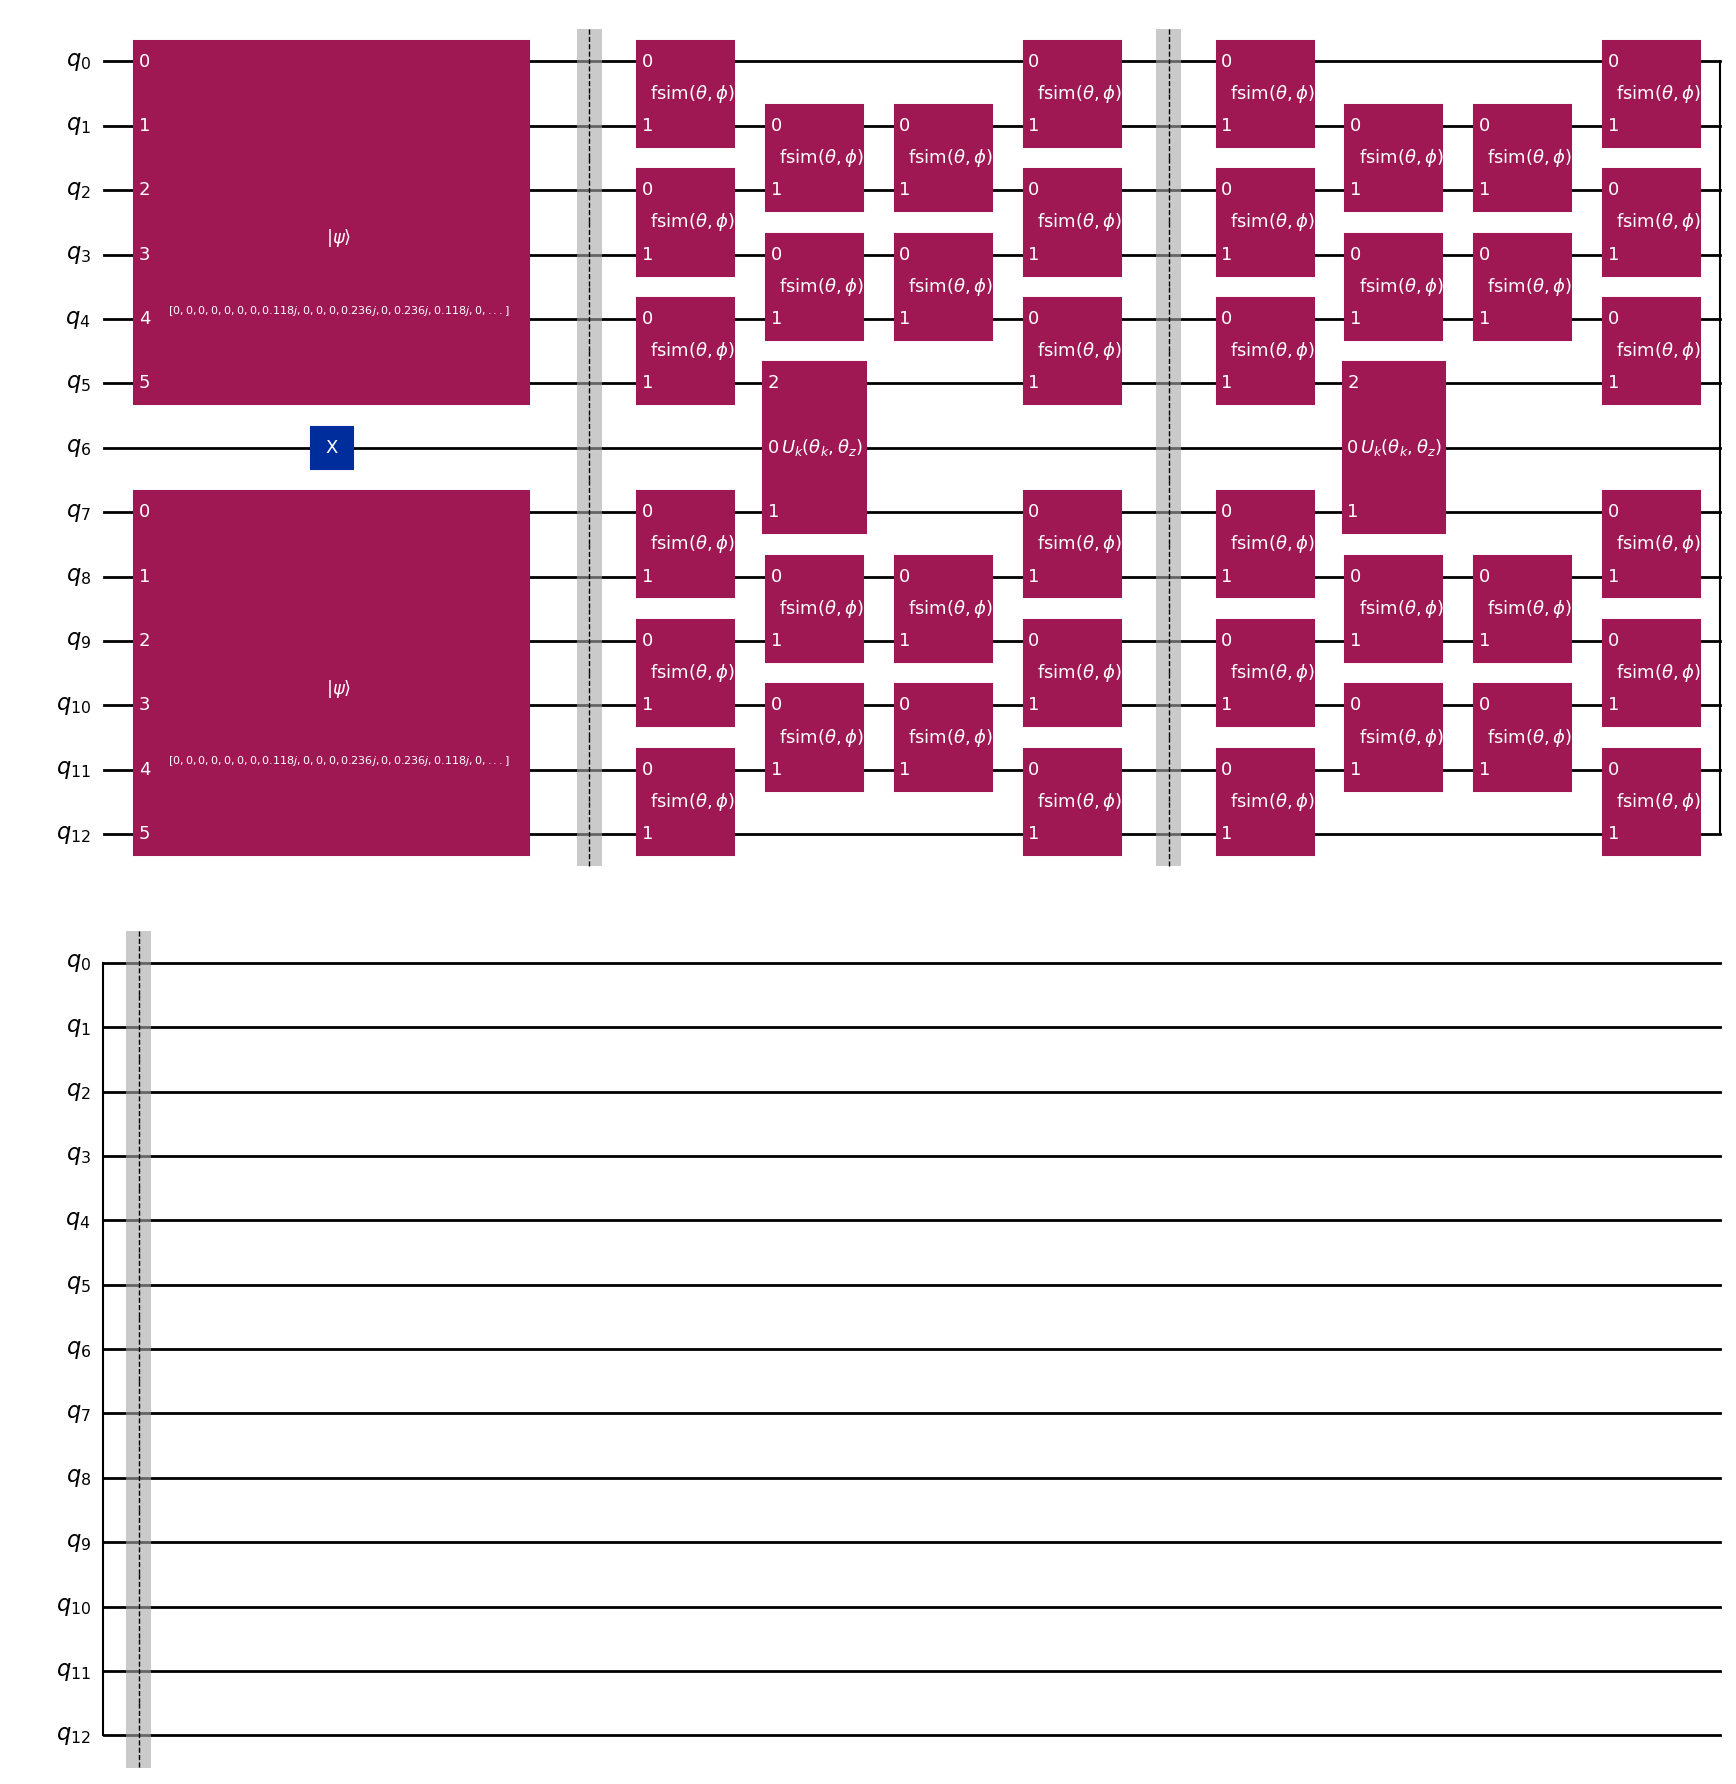

In [37]:
#Now we add the entire kondo circuit. This is the more efficient layered version as seen in our discussion

# Let us use the direct 8 by 8 unitary now for the problem

def kondo_unitary(theta_k,theta_z):

    l1 = cm.exp(1j*theta_z/2)
    l2 = cm.exp(-1j*theta_z/2)
    c1 = m.cos(theta_k)
    s1 = m.sin(theta_k)

    a = m.cos(np.sqrt(2)*theta_k) - (1j/np.sqrt(2))*m.sin(np.sqrt(2)*theta_k)
    a_dag = m.cos(np.sqrt(2)*theta_k) + (1j/np.sqrt(2))*m.sin(np.sqrt(2)*theta_k)
    b = (-1j/np.sqrt(2))*m.sin(np.sqrt(2)*theta_k)
    c = cm.exp(-1j*theta_k) 
    d = cm.exp(1j*theta_k)

    """kondo_unitary = Operator([[1,0,0,0,0,0,0,0],
                          [0,1,0,0,0,0,0,0],
                          [0,0,l1,0,0,0,0,0],
                          [0,0,0,c1*l2,1j*l2*s1,0,0,0],
                          [0,0,0,1j*l2*s1,c1*l2,0,0,0],
                          [0,0,0,0,0,l1,0,0],
                          [0,0,0,0,0,0,1,0],
                          [0,0,0,0,0,0,0,1]])"""
    kondo_unitary = Operator([[1,0,0,0,0,0,0,0],
                          [0,a,0,0,0,0,b,0],
                          [0,0,1,0,0,0,0,0],
                          [0,0,0,d,0,0,0,0],
                          [0,0,0,0,c,0,0,0],
                          [0,0,0,0,0,1,0,0],
                          [0,b,0,0,0,0,a_dag,0],
                          [0,0,0,0,0,0,0,1]])
    
    kondo_unitary_2 = Operator([[1,0,0,0,0,0,0,0],
                          [0,1,0,0,0,0,0,0],
                          [0,0,c1*l1,0,0,1j*s1*l1,0,0],
                          [0,0,0,l2,0,0,0,0],
                          [0,0,0,0,l2,0,0,0],
                          [0,0,1j*s1*l1,0,0,c1*l1,0,0],
                          [0,0,0,0,0,0,1,0],
                          [0,0,0,0,0,0,0,1]])
    
    return kondo_unitary_2

def circuit_3(N, pos_list, trotter_steps,angles = [0,0,0],theta_k = 0,theta_z = 0, num_cl_bits = 0, trotter_barriers = False, save = False):
    if num_cl_bits == 0:
        qc = fermi_state_circuit(N)
    else:
        qc = fermi_state_circuit(N,num_cl_bits)
    qc.x(N)
    qc.barrier()
    
    c = num_qubits//2
    for i in range(trotter_steps):
        add_fsim_half(qc,angles)
        qc.unitary(kondo_unitary(theta_k,theta_z),[c,c+1,c-1],label=r'$U_{k}(\theta_k,\theta_z)$')
        add_fsim_inv_half(qc,angles)
        if trotter_barriers:
            qc.barrier()
    if save == True:
        qc.save_statevector()
    #qc.save_statevector()  remove save for changing to operator
    return qc

qc = circuit_3(N,[2*N],test_trotter_steps,angles,trotter_barriers = True)
qc.draw(output = 'mpl')

## Plotting  < H_t + H_k >

In [38]:
max_trotter_steps = 20  #int (10/theta_k)
measured_bits =list(range(2*N + 1))
theta_k = np.pi/6  #To check whether if kondo circuit is messing up the spin conservation (use corrected one)
theta_z = -theta_k  #Can be equal to theta_k as well, depending on written Hamiltonian form

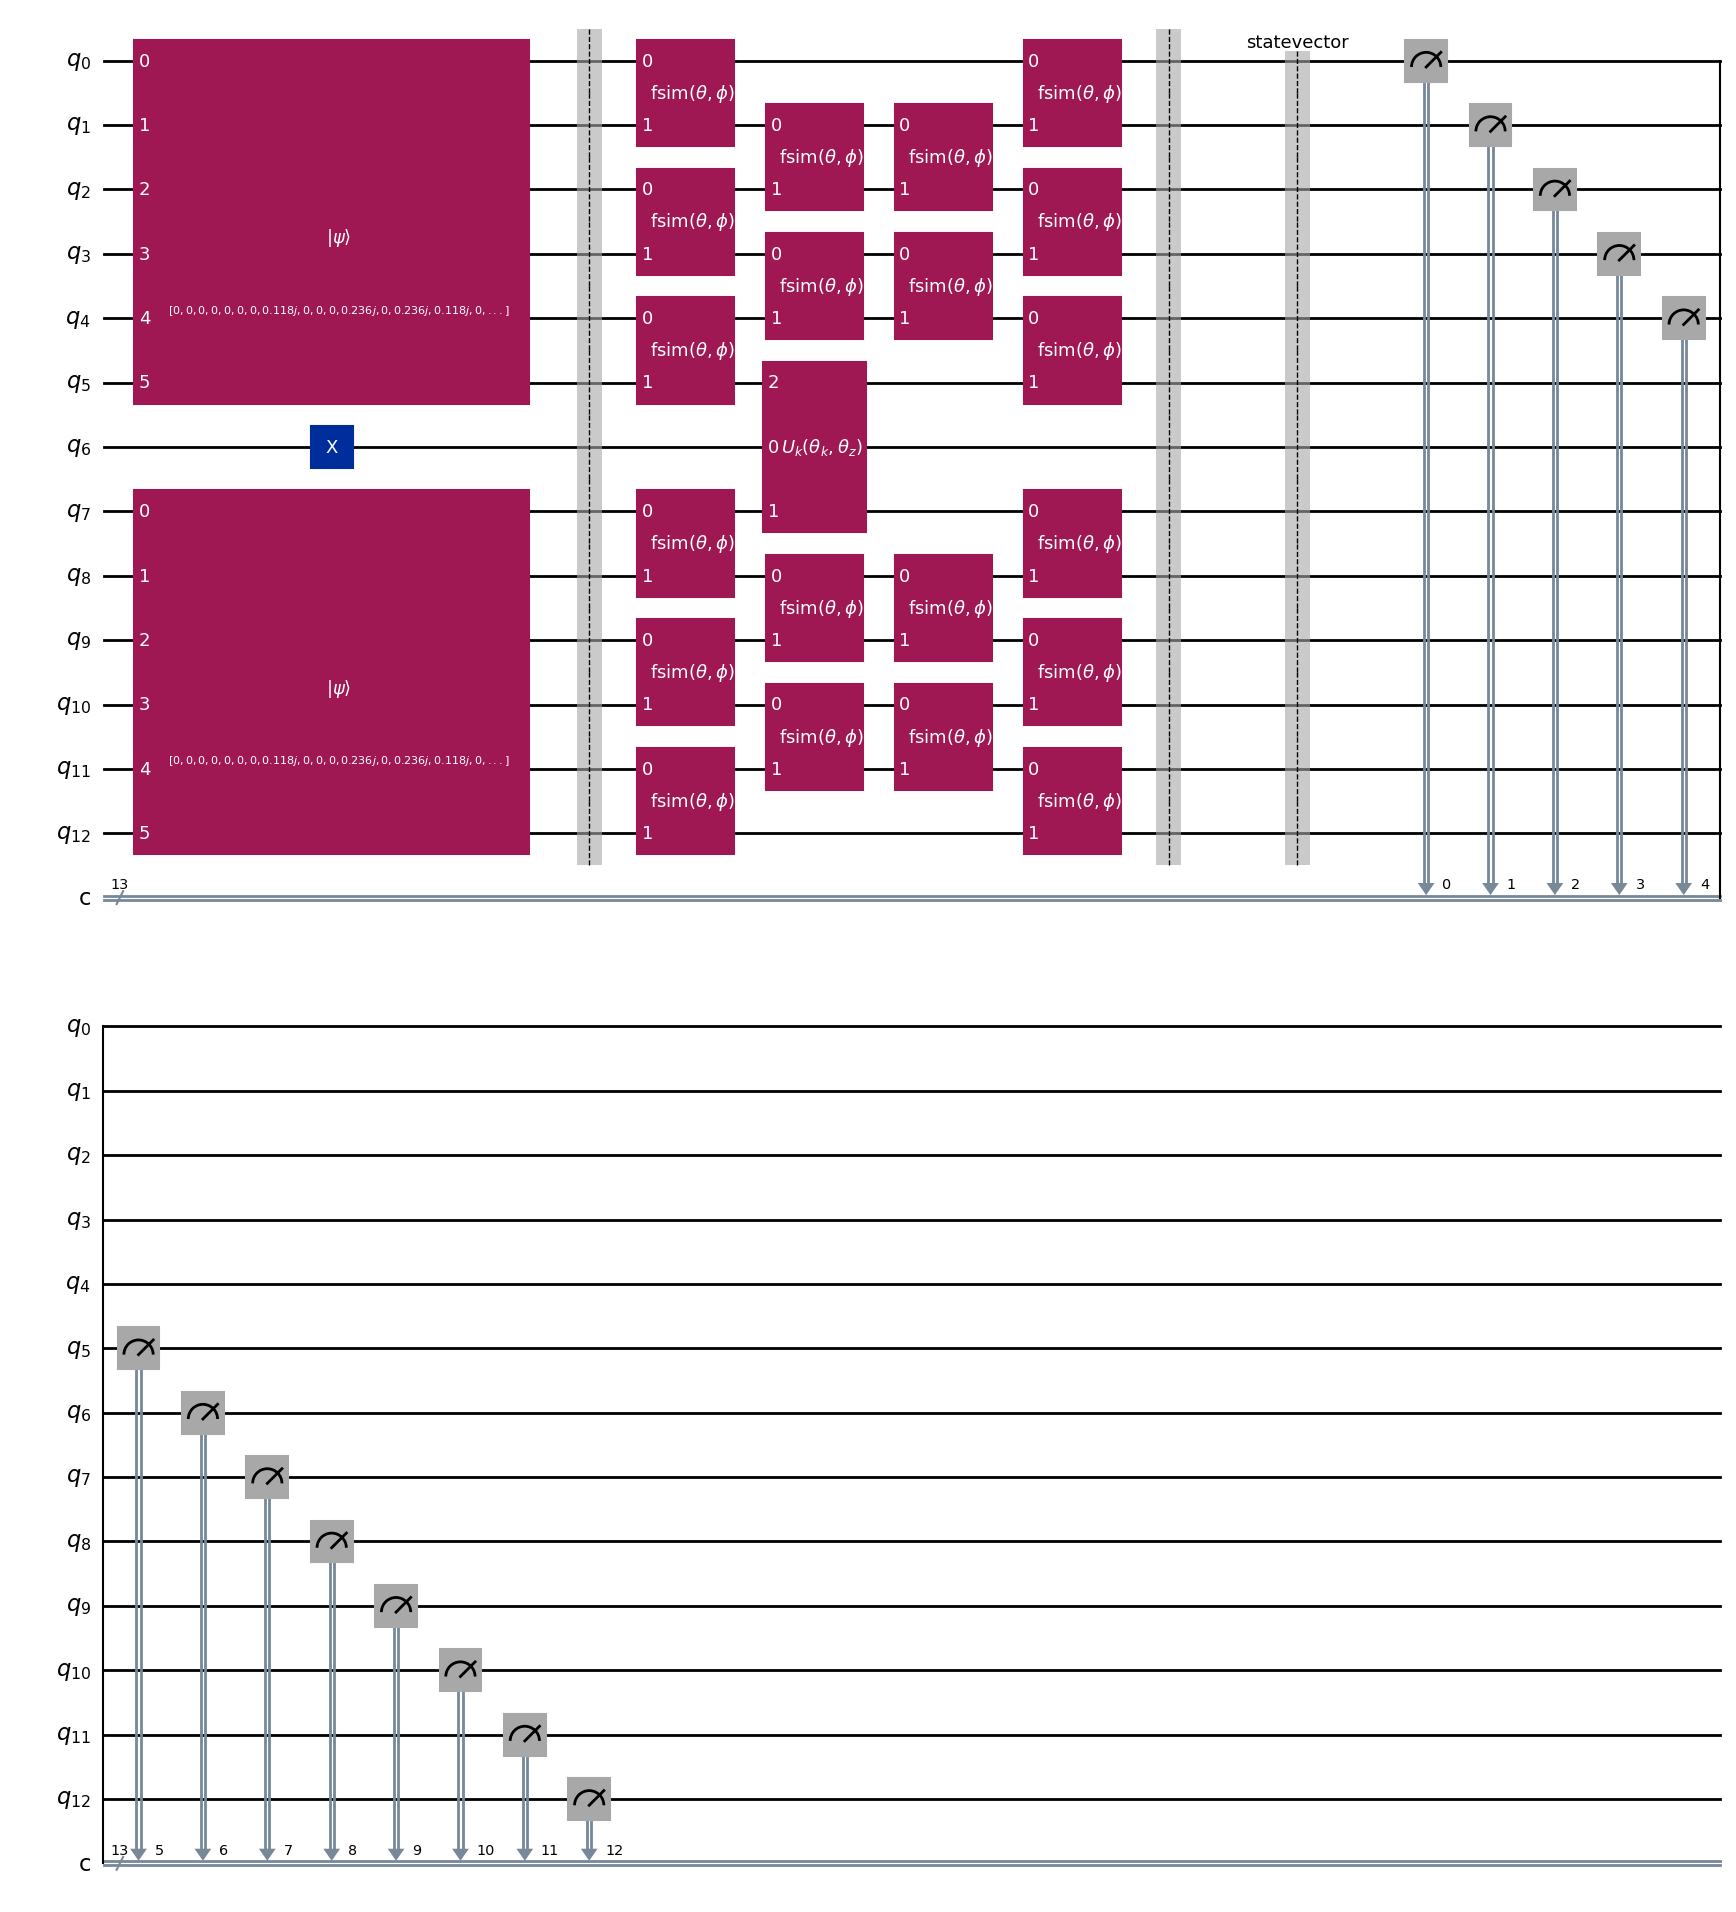

In [39]:
qc_list = []
for t in range(max_trotter_steps):
    qc = circuit_3(N,[0,1,2*N], t, angles, num_cl_bits = len(measured_bits),theta_k=theta_k,theta_z=theta_z, trotter_barriers = True, save = True)
    qc.measure(measured_bits,list(range(len(measured_bits))))
    qc_list.append(qc)

qc_list[1].draw(output = "mpl")

In [11]:
estimator = Estimator(approximation='True')

In [40]:
def total_herm_check(qc_list, theta, theta_k):
    H_t = 0
    H_k = 0
    for i in range(2*N):
        if i==N-1 or i==N:
            continue
        else:
            H_t += -theta*(SparsePauliOp('I'*(i) + 'XX' + 'I'*(2*N-i-1)) + SparsePauliOp('I'*(i) + 'YY' + 'I'*(2*N-i-1)))
    H_k = (-theta_k/2)*(SparsePauliOp('I'*(N-1) + 'XXX' + 'I'*(N-1))+SparsePauliOp('I'*(N-1) + 'YXY' + 'I'*(N-1)) + SparsePauliOp('I'*(N-1) + 'XYY' + 'I'*(N-1))- SparsePauliOp('I'*(N-1) + 'YYX' + 'I'*(N-1))+ SparsePauliOp('I'*(N) + 'ZZ' + 'I'*(N-1)) - SparsePauliOp('I'*(N-1) + 'ZZ' + 'I'*(N)))
    h_analytical = [H_t + H_k]*max_trotter_steps
    print("Operator obtained from circuit")
    #h_fromcirc = [Operator.from_circuit(qc) for qc in qc_list]
    job_analytical = estimator.run(qc_list,h_analytical,shots = None)
    print("Analytical run complete")
    #job_fromcirc = estimator.run(qc_list,h_fromcirc,shots = None)
    print("Circuit run complete")

    h_values1 = list(job_analytical.result().values)
    #h_values2 = list(job_fromcirc.result().values)

    print("Plotting the results....")

    plt.plot(range(max_trotter_steps),h_values1,label = 'Total Hamiltonian analytical')
    #plt.plot(range(max_trotter_steps),h_values2,label = 'Total Hamiltonian from circuit')
    plt.xlabel('Time (trotter steps)')
    plt.ylabel(r'$\langle H(t) \rangle$')
    plt.legend()

Operator obtained from circuit
Analytical run complete
Circuit run complete
Plotting the results....


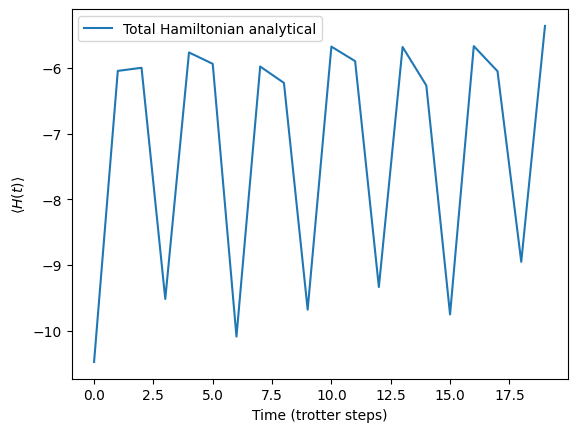

In [41]:
total_herm_check(qc_list,angles[0],theta_k)

## Utilize S-tomography to obtain the reduced density matrix

In [42]:
## Let us first form the density matrix list arising from the circuit list
from qiskit.quantum_info import partial_trace # To check later whether our derived density matrix is correct
from qiskit.quantum_info import DensityMatrix
simulator_aer = AerSimulator()
def get_density_matrix(qc_list):
    density_matrix_list = []
    for qc in qc_list:
        qc_aer = transpile(qc, backend=simulator_aer)
        result = simulator_aer.run(qc_aer).result()

        state = result.get_statevector()
        #print(state.is_valid())
        #print(state)
        density_matrix = DensityMatrix(state)
        density_matrix_list.append(density_matrix)
    return density_matrix_list

density_matrix_list = get_density_matrix(qc_list)

In [43]:
# We form the partial trace of density matrix via qiskit's predefined function

qargs = list(range(N)) + list(range(N+1,2*N+1))
reduced_dm_qiskit = []
for dm in density_matrix_list:
    reduced_dm = partial_trace(dm,qargs)
    reduced_dm_qiskit.append(reduced_dm)
    

In [44]:
test = np.array([[1,0],[0,1]])
print(test)

test_dm = DensityMatrix(test)
print(test_dm)

[[1 0]
 [0 1]]
DensityMatrix([[1.+0.j, 0.+0.j],
               [0.+0.j, 1.+0.j]],
              dims=(2,))


In [45]:
# Now we form the reduced density matrix from the circuit using X,Y,Z observables on the impurity site

Z_imp_observables = [SparsePauliOp('I'*(N) + 'Z' + 'I'*(N))]*max_trotter_steps
X_imp_observables = [SparsePauliOp('I'*(N) + 'X' + 'I'*(N))]*max_trotter_steps
Y_imp_observables = [SparsePauliOp('I'*(N) + 'Y' + 'I'*(N))]*max_trotter_steps

Z_avg = estimator.run(qc_list,Z_imp_observables,shots = None)
X_avg = estimator.run(qc_list,X_imp_observables,shots = None)
Y_avg = estimator.run(qc_list,Y_imp_observables,shots = None)

Z_values = list(Z_avg.result().values)
X_values = list(X_avg.result().values)
Y_values = list(Y_avg.result().values)

reduced_dm_tomo = []
for i in range(max_trotter_steps):
    reduced_dm = DensityMatrix((1/2)*(np.eye(2) + X_values[i]*np.array([[0,1],[1,0]]) + Y_values[i]*np.array([[0,-1j],[1j,0]]) + Z_values[i]*np.array([[1,0],[0,-1]])))
    reduced_dm_tomo.append(reduced_dm)



In [46]:
print(reduced_dm_tomo[2])
print(reduced_dm_qiskit[2])  #The reduced density matrix from the circuit and the one from the tomography should be the same

DensityMatrix([[0.09326172+0.j, 0.        +0.j],
               [0.        +0.j, 0.90673828+0.j]],
              dims=(2,))
DensityMatrix([[0.09326172-1.56253282e-19j, 0.        +0.00000000e+00j],
               [0.        +0.00000000e+00j, 0.90673828+4.79850148e-19j]],
              dims=(2,))


In [19]:
from qiskit.quantum_info import purity
from scipy import linalg as la

In [20]:
def trace_norm(density_matrix):
    density_matrix = np.array(density_matrix)
    eigenvalues, eigenvectors = np.linalg.eig(density_matrix)
    sum = 0
    #print(eigenvalues)
    for i in eigenvalues:
        if i.real < 0:
            sum += i.real
    #print(sum)
    return abs(sum)

def calculate_entropy(rho):
    rho = np.array(rho)
    R = rho*(la.logm(rho))
    S = -np.matrix.trace(R)
    return S


def von_neumann_entropy(reduced_dm_list):
    entropy_list = []
    for dm in reduced_dm_list:
        entropy = calculate_entropy(dm)
        entropy_list.append(entropy)
    return entropy_list

def negativity(density_matrix_list):
    neg_list = []
    for density_matrix in density_matrix_list:
        dm_pt = density_matrix.partial_transpose([N])
        neg = trace_norm(dm_pt)
        #print(neg)
        neg_list.append(neg.real)
    return neg_list

def concurrence(reduced_dm_list):
    concurrence_list = []
    for dm in reduced_dm_list:
        c = purity(dm).real
        if c>1:
            c = 1
            print("Purity is greater than 1,by a value of:",c-1)
        concurrence_list.append(np.sqrt(2*(1-c)))
    return concurrence_list

d:\Anaconda\envs\qiskitenv\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
d:\Anaconda\envs\qiskitenv\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


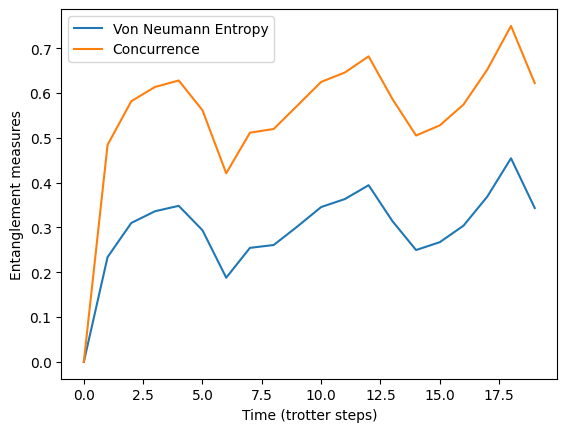

In [47]:
von_neumann_entropy_list = von_neumann_entropy(reduced_dm_tomo)
#negativity_list = negativity(density_matrix_list)    #Takes a tremendous amount of time.... best calculated in a separate script/cell
concurrence_list = concurrence(reduced_dm_tomo)

plt.plot(range(max_trotter_steps),von_neumann_entropy_list,label = 'Von Neumann Entropy')
#plt.plot(range(max_trotter_steps),negativity_list,label = 'Negativity')
plt.plot(range(max_trotter_steps),concurrence_list,label = 'Concurrence')
plt.xlabel('Time (trotter steps)')
plt.ylabel('Entanglement measures')
plt.legend()

## Code for Kondo Cloud measurement

In [22]:
# Let us first get a state_list
state_list = []
simulator_aer = AerSimulator()
for qc in qc_list:
    qc_aer = transpile(qc, backend=simulator_aer)
    result = simulator_aer.run(qc_aer).result()
   
    state = result.get_statevector()
    print("Got final state, appending it to state_list...")
    state_list.append(state) 

Got final state, appending it to state_list...
Got final state, appending it to state_list...
Got final state, appending it to state_list...
Got final state, appending it to state_list...
Got final state, appending it to state_list...
Got final state, appending it to state_list...
Got final state, appending it to state_list...
Got final state, appending it to state_list...
Got final state, appending it to state_list...
Got final state, appending it to state_list...
Got final state, appending it to state_list...
Got final state, appending it to state_list...
Got final state, appending it to state_list...
Got final state, appending it to state_list...
Got final state, appending it to state_list...
Got final state, appending it to state_list...
Got final state, appending it to state_list...
Got final state, appending it to state_list...
Got final state, appending it to state_list...
Got final state, appending it to state_list...


In [49]:
sampler = Sampler()
job = sampler.run(qc_list,shots = 1000)
result = job.result()


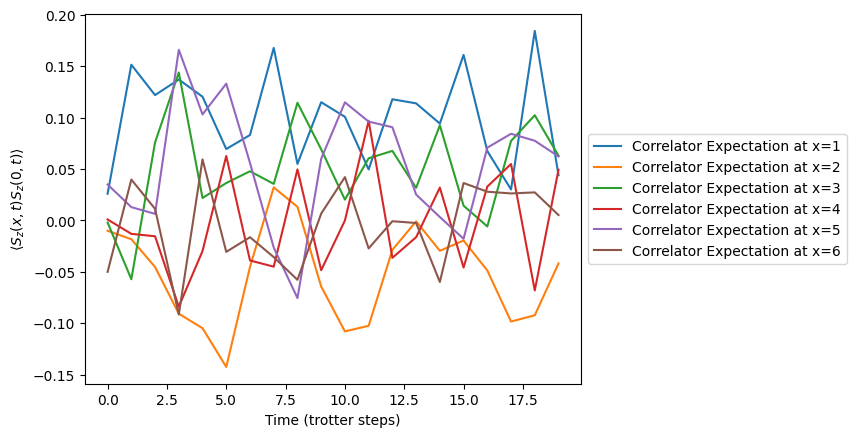

In [50]:
pos1 = 0  #position of lead site, starting from 0
pos2 = 1
pos3 = 2
pos4 = 3
pos5 = 4
pos6 = 5
#dis = pos + 1  #distance of the impurity from the position (normal distance measure)

#Create the correlator operator
    

def correlator_expectation(pos,bitstr_dict):
    imp_mag = 0
    pos_mag = 0
    for bstr in bitstr_dict.keys():
        imp_mag += (bstr[N].count('0') - bstr[N].count('1'))*bitstr_dict[bstr]
        pos_mag += (bstr[N-(pos+1)].count('0') - bstr[N+(pos+1)].count('0'))*bitstr_dict[bstr]
        #print("Imp_mag:",imp_mag, "Pos_mag:",pos_mag)
    return (imp_mag*pos_mag)/1000000  #divide further by 4 to get the actual expectation value of S_z(0)S_z(dis)

def correlator_expectation_calc(pos):
    exp_values = []
    for i in range(max_trotter_steps):
        bitstr_dict = result[i].data.c.get_counts()
        exp_values.append(correlator_expectation(pos,bitstr_dict))
    return exp_values

correlator_expectation_list1 = correlator_expectation_calc(pos1)
correlator_expectation_list2 = correlator_expectation_calc(pos2)
correlator_expectation_list3 = correlator_expectation_calc(pos3)
correlator_expectation_list4 = correlator_expectation_calc(pos4)
correlator_expectation_list5 = correlator_expectation_calc(pos5)
correlator_expectation_list6 = correlator_expectation_calc(pos6)


plt.plot(range(max_trotter_steps),correlator_expectation_list1,label = f'Correlator Expectation at x={pos1+1}')
plt.plot(range(max_trotter_steps),correlator_expectation_list2,label = f'Correlator Expectation at x={pos2+1}')
plt.plot(range(max_trotter_steps),correlator_expectation_list3,label = f'Correlator Expectation at x={pos3+1}')
plt.plot(range(max_trotter_steps),correlator_expectation_list4,label = f'Correlator Expectation at x={pos4+1}')
plt.plot(range(max_trotter_steps),correlator_expectation_list5,label = f'Correlator Expectation at x={pos5+1}')
plt.plot(range(max_trotter_steps),correlator_expectation_list6,label = f'Correlator Expectation at x={pos6+1}')
plt.xlabel('Time (trotter steps)')
plt.ylabel(r'$ \langle S_z(x,t)S_z(0,t) \rangle$')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

        


## Tests to confirm spin conservation

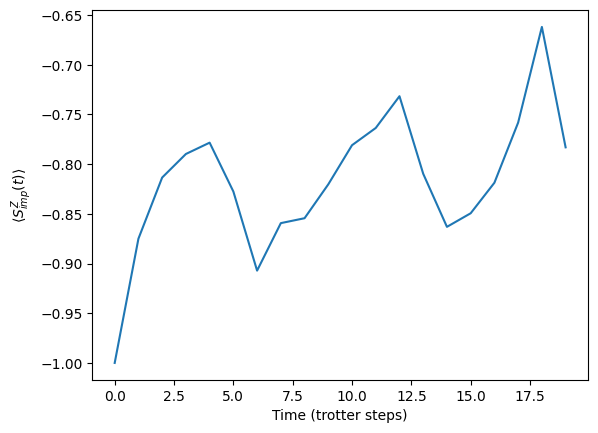

In [51]:
imp_observables = [SparsePauliOp('I'*N + 'Z' + 'I'*N)]*max_trotter_steps
job_1 = estimator.run(qc_list,imp_observables,shots = None)
expectation_list_1 = list(job_1.result().values)
plt.plot(range(max_trotter_steps),expectation_list_1,label = 'Impurity')
plt.xlabel('Time (trotter steps)')
plt.ylabel(r'$\langle S^Z_{imp}(t) \rangle$')
plt.show()

In [52]:
def total_ferm_mag(bitstr_dict):
    total_ferm_mag = 0
    for bstr in bitstr_dict.keys():
        #print(bstr)
        #print(bstr[N+1:].count('0'))
        #print(bstr[:N].count('0'))
        total_ferm_mag += (bstr[0:N].count('0') - bstr[N+1:].count('0'))*bitstr_dict[bstr]
    return total_ferm_mag

def check_mag(qc_list):
    #sampler = Sampler()
    #job = sampler.run(qc_list,shots = 1000)
    #result = job.result()
    ferm_mag_arr = []
    for i in range(len(qc_list)):
        #print(result[i].data.c.get_counts())
        ferm_mag_arr.append(total_ferm_mag(result[i].data.c.get_counts())/1000)


    ferm_mag_arr = np.array(ferm_mag_arr)
    #print(ferm_mag_arr)
    final_ferm_mag = ferm_mag_arr + expectation_list_1
    print(final_ferm_mag)
    
    plt.plot(range(max_trotter_steps),final_ferm_mag, label = 'Total magnetization')
    #plt.plot(range(max_trotter_steps),expectation_list_1,label = 'Impurity magnetization')
    plt.xlabel('Time (trotter steps)')
    plt.ylabel(r'Magnetization values')
    plt.legend()

[-1.         -1.009      -1.00547656 -1.02777802 -0.99637712 -0.97953634
 -1.00312674 -1.0113455  -0.96640423 -0.98631469 -0.99894525 -0.98759788
 -1.03365049 -0.99569326 -1.02108582 -1.00141623 -0.99470557 -0.98419231
 -1.02593095 -1.02308924]


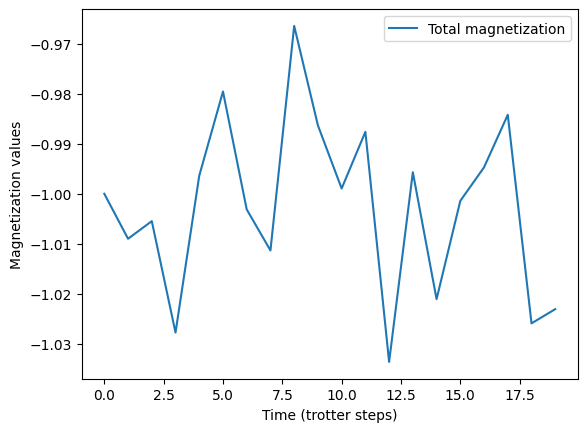

In [53]:
check_mag(qc_list)